#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
# Testing if integration works

In [2]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [3]:
file_name = '/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002653.h5'
hf = h5py.File(file_name)

In [4]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0003060228089399144, 'norm': 0.09763003458121172, 'patient_id': 'b6a4d553d5c93ee658ceabb41ea6395ac1bd7a7ffd1239233c821f32a981c19c'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [5]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 640, 320)


In [7]:
slice_kspace = volume_kspace[8] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [8]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

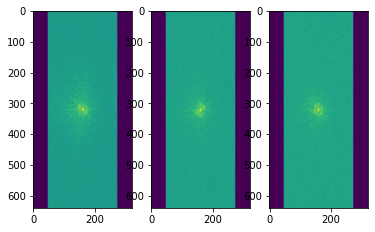

In [9]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [27]:
import fastmri
from fastmri.data import transforms as T
print("The dimension before converting to PyTorch tensor is: ", slice_kspace.shape)

The dimension before converting to PyTorch tensor is:  (16, 640, 320)


In [11]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

In [30]:
print("The dimension before converting to PyTorch tensor is: ", slice_kspace.shape)
print("The dimension after calling to_tensor is: ", slice_kspace2.shape)
print("The complex image dimensions (after iFT) are: ", slice_image.shape)
print("The dimensions of the real image (after taking abs. value) are: ", slice_image_abs.shape)

The dimension before converting to PyTorch tensor is:  (16, 640, 320)
The dimension after calling to_tensor is:  torch.Size([16, 640, 320, 2])
The complex image dimensions (after iFT) are:  torch.Size([16, 640, 320, 2])
The dimensions of the real image (after taking abs. value) are:  torch.Size([16, 640, 320])


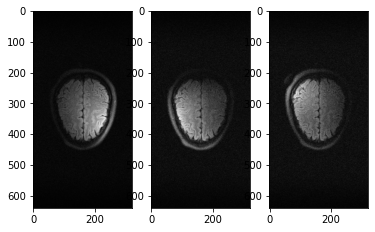

In [12]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [31]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

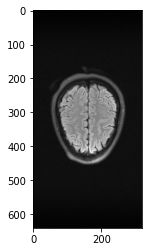

In [32]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [33]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [34]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

In [40]:
print("The dimensions of the PyTorch tensor complex image is: ", slice_kspace2.shape)
print("The dimension of the masked kspace is: ", masked_kspace.shape)
print("The dimension of the mask itself is: ", mask.shape)



The dimensions of the PyTorch tensor complex image is:  torch.Size([16, 640, 320, 2])
The dimension of the masked kspace is:  torch.Size([16, 640, 320, 2])
The dimension of the mask itself is:  torch.Size([1, 1, 320, 1])


Let's see what the subsampled image looks like:

In [41]:
sampled_image = fastmri.ifft2c(masked_kspace)            # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

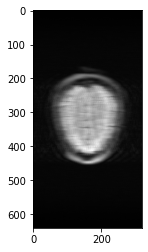

In [42]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')